# Exploring precision and recall

The goal of this second notebook is to understand precision-recall in the context of classifiers.

 * Use Amazon review data in its entirety.
 * Train a logistic regression model.
 * Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
 * Explore how various metrics can be combined to produce a cost of making an error.
 * Explore precision and recall curves.
 
Because we are using the full Amazon review dataset (not a subset of words or reviews), in this assignment we will use built-in functions in scikit-learn.

In [88]:
import pandas as pd
import numpy as np
import json
import string
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load amazon review dataset

In [89]:
products = pd.read_csv('data_files/amazon_baby.csv')
products.head(3)

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5


## Text cleaning

In [90]:
products = products.fillna({'review':''})

In [91]:
def remove_punctuation(text):
    translator = str.maketrans('','', string.punctuation)
    return text.translate(translator)

products['review_clean'] = products['review'].apply(remove_punctuation)
products.head(3)

,name,review,rating,review_clean
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,These flannel wipes are OK but in my opinion n...
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...


### Extract Sentiment

In [92]:
products = products[products['rating'] != 3]

In [93]:
products['sentiment'] = products['rating'].apply(lambda x: +1 if x>3 else -1)

## Split data into training and test sets

We split the data into a 80-20 split where 80% is in the training set and 20% is in the test set.

In [94]:
with open('data_files/module-9-assignment-train-idx.json') as train_data_file:    
    train_data_idx = json.load(train_data_file)
with open('data_files/module-9-assignment-test-idx.json') as test_data_file:    
    test_data_idx = json.load(test_data_file)

train_data = products.iloc[train_data_idx]
test_data = products.iloc[test_data_idx]

In [95]:
print(train_data.shape, test_data.shape)

(133416, 5) (33336, 5)


## Build word count vector for each review

In [96]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words and skip some unimportant words like 'it'
# First, learn vocabulary from the training data and assign columns to words, Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])
#print (vectorizer.vocabulary_)

In [97]:
print(train_matrix.shape, test_matrix.shape)

(133416, 121712) (33336, 121712)


## Train a classifier using logistic regression

In [98]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter = 10000)       # set max iteration for maximum likelihood estimation(gradient ascent)
model.fit(train_matrix, train_data['sentiment'])

LogisticRegression(max_iter=10000)

# Model Evaluation

We will explore the advanced model evaluation concepts that were discussed in the lectures.

## Accuracy

One performance metric we will use for our more advanced exploration is accuracy, which we have seen many times in past assignments.  Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$

To obtain the accuracy of our trained models using Turi Create, simply pass the option `metric='accuracy'` to the `evaluate` function. We compute the **accuracy** of our logistic regression model on the **test_data** as follows:

In [99]:
from sklearn.metrics import accuracy_score  #accuracy_score: number of correctly classified data points/total data points
accuracy = accuracy_score(y_true = test_data['sentiment'].to_numpy(), 
                          y_pred = model.predict(test_matrix))
print('The prediction accuracy on test data is:', accuracy)

The prediction accuracy on test data is: 0.9322954163666907


## Baseline: Majority class prediction

Recall from an earlier assignment that we used the **majority class classifier** as a baseline (i.e reference) model for a point of comparison with a more sophisticated classifier. The majority classifier model predicts the majority class for all data points. 

Typically, a good model should beat the majority class classifier. Since the majority class in this dataset is the positive class (i.e., there are more positive than negative reviews), the accuracy of the majority class classifier can be computed as follows:

In [100]:
baseline = len(test_data[test_data['sentiment']==1])/len(test_data)
print ('Baseline accuracy (majority class classifier):',baseline)

Baseline accuracy (majority class classifier): 0.8427825773938085


## Confusion Matrix

In [101]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true = test_data['sentiment'].to_numpy(),
                        y_pred = model.predict(test_matrix),
                        labels = model.classes_)    # use the same order of class as the LR model.
print (' target_label | predicted_label | count ')
print ('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print ('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3788
     -1       |        1        |  1453
      1       |       -1        |   804
      1       |        1        | 27291


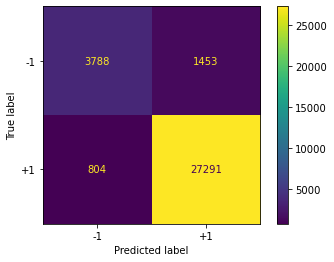

In [102]:
plot_confusion_matrix(model, test_matrix, test_data['sentiment'], display_labels =['-1','+1'])

## Computing the cost of mistakes


Put yourself in the shoes of a manufacturer that sells a baby product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints.  Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, **false positives cost more than false negatives**. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake: 
1. \$100 for each false positive.
2. \$1 for each false negative.
3. Correctly classified reviews incur no cost.

In [103]:
total_cost = 100*1453 +1*804
print(total_cost)

146104


## Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher. 


A complementary metric is **recall**, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

Let us compute the recall on the **test_data**.

#### Calculate Precision and recall

In [104]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=model.predict(test_matrix))
FP_perct=1-precision
print(FP_perct)
print(precision)

0.05054967993320347
0.9494503200667965


In [105]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=model.predict(test_matrix))
print(recall)

0.9713828083288841


# Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture.  We first examine what happens when we use a different threshold value for making class predictions.  We then explore a range of threshold values and plot the associated precision-recall curve.  

## Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold. 

Write a function called `apply_threshold` that accepts two things
* `probabilities` (an SArray of probability values)
* `threshold` (a float between 0 and 1).

The function should return an SArray, where each element is set to +1 or -1 depending whether the corresponding probability exceeds `threshold`.

##### way1: create a new column in the dataset and use .apply() fucntion;
##### way2: directly create a array not through dataset (following four different ways);

In [106]:
def apply_threshold_1(probabilities, threshold):
    result = np.ones(len(probabilities))  #numpy.ndarray
    result[probabilities < threshold] = -1
    
    return result

In [107]:
def apply_threshold_2(probabilities, threshold):
    return np.array([+1 if p >= threshold else -1 for p in probabilities]) 

In [108]:
def apply_threshold_3 (probabilities,threshold):
    prediction=np.zeros(len(probabilities))
    
    for i in range(len(probabilities)):
        if probabilities[i] >=threshold:
            prediction[i] = 1
        else:
            prediction[i] = -1
    return prediction  

In [109]:
def apply_threshold_4 (probabilities,threshold):
    prediction_all=[]
    for i in range(len(probabilities)):
        if probabilities[i] >=threshold:
            prediction = 1
        else:
            prediction = -1
        prediction_all.append(prediction)  # when using append: prediction has no subscript 
    return prediction_all                 

In [110]:
probabilities = model.predict_proba(test_matrix)[:,1]  # probability of being +1
print(type(probabilities))
print(probabilities[:5])

<class 'numpy.ndarray'>
[0.78432916 0.99999924 0.93321071 0.99997943 0.98026733]


In [111]:
prediction = apply_threshold_4(probabilities,0.6)
sum(prediction)

23200

In [112]:
# threshold = 0.5
predictions_with_default_threshold = apply_threshold_3(probabilities, 0.5)
print(np.sum(predictions_with_default_threshold == 1))

precision_with_default_threshold = precision_score(y_true=test_data['sentiment'], y_pred=predictions_with_default_threshold)
print('The precision with default threshold is:',precision_with_default_threshold)

recall_with_default_threshold = recall_score(y_true=test_data['sentiment'], y_pred=predictions_with_default_threshold)
print('The recall with default threshold is:',recall_with_default_threshold)

# threshold = 0.9
predictions_with_high_threshold = apply_threshold_3(probabilities, 0.9)
print(np.sum(predictions_with_high_threshold == 1))

precision_with_high_threshold = precision_score(y_true=test_data['sentiment'], y_pred=predictions_with_high_threshold)
print('The precision with threshold=0.9:',precision_with_high_threshold)

recall_with_high_threshold = recall_score(y_true=test_data['sentiment'], y_pred=predictions_with_high_threshold)
print('The recall with threshold=0.9:', recall_with_high_threshold)

28744
The precision with default threshold is: 0.9494503200667965
The recall with default threshold is: 0.9713828083288841
25072
The precision with threshold=0.9: 0.9814932992980216
The recall with threshold=0.9: 0.8758853888592276


As the threshold goes up, false positive will decrease, so precision score goes up. On the other hand, false negative will increase, so recall score will goes down.

## Exploring the associated precision and recall as the threshold varies

In [113]:
threshold_values = np.linspace(0.5, 1, num=100)
threshold_values

array([0.5       , 0.50505051, 0.51010101, 0.51515152, 0.52020202,
       0.52525253, 0.53030303, 0.53535354, 0.54040404, 0.54545455,
       0.55050505, 0.55555556, 0.56060606, 0.56565657, 0.57070707,
       0.57575758, 0.58080808, 0.58585859, 0.59090909, 0.5959596 ,
       0.6010101 , 0.60606061, 0.61111111, 0.61616162, 0.62121212,
       0.62626263, 0.63131313, 0.63636364, 0.64141414, 0.64646465,
       0.65151515, 0.65656566, 0.66161616, 0.66666667, 0.67171717,
       0.67676768, 0.68181818, 0.68686869, 0.69191919, 0.6969697 ,
       0.7020202 , 0.70707071, 0.71212121, 0.71717172, 0.72222222,
       0.72727273, 0.73232323, 0.73737374, 0.74242424, 0.74747475,
       0.75252525, 0.75757576, 0.76262626, 0.76767677, 0.77272727,
       0.77777778, 0.78282828, 0.78787879, 0.79292929, 0.7979798 ,
       0.8030303 , 0.80808081, 0.81313131, 0.81818182, 0.82323232,
       0.82828283, 0.83333333, 0.83838384, 0.84343434, 0.84848485,
       0.85353535, 0.85858586, 0.86363636, 0.86868687, 0.87373

In [114]:
precision_all = []
recall_all = []

probabilities = model.predict_proba(test_matrix)[:,1]
for threshold in threshold_values:
    predictions = apply_threshold_2(probabilities, threshold)
    
    precision = precision_score(y_true = test_data['sentiment'], y_pred = predictions)
    recall = recall_score(y_true = test_data['sentiment'], y_pred = predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

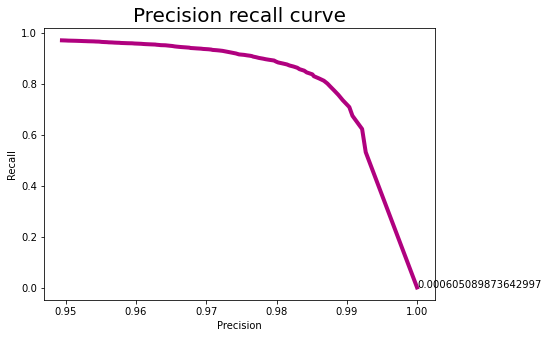

In [115]:
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(precision_all, recall_all, linewidth = 4.0, color = '#B0017F')
ax.set_title('Precision recall curve', fontsize = 20)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.text(1,0,recall_all[-1])
plt.show()

As precision increase, recall will goes down, when precision=1, meaning false positive is 0, so number of false negative is very large, then recall will be extremely small.

# Evaluating specific search terms

So far, we looked at the number of false positives for the **entire test set**. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

## Precision-Recall on all baby related items

From the **test set**, select all the reviews for all products with the word 'baby' in them.

In [116]:
test_data.head(2)

,name,review,rating,review_clean,sentiment
9,"Baby Tracker&reg; - Daily Childcare Journal, S...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
10,"Baby Tracker&reg; - Daily Childcare Journal, S...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1


In [117]:
test_data['name'] = test_data['name'].astype(str)

<ipython-input-117-99b61e28e9f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['name'] = test_data['name'].astype(str)


In [118]:
baby_reviews =  test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]
print(baby_reviews.shape)

(6611, 5)


In [119]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

In [120]:
threshold_values = np.linspace(0.5, 1, num=100)

In [121]:
precision_all = []
recall_all = []

for threshold in threshold_values:
    
    # Make predictions. Use the `apply_threshold` function 
    ## YOUR CODE HERE 
    predictions = apply_threshold_4(probabilities, threshold)

    # Calculate the precision.
    # YOUR CODE HERE
    precision = precision_score(y_true = baby_reviews['sentiment'], y_pred = predictions)
    
    # YOUR CODE HERE
    recall = recall_score(y_true = baby_reviews['sentiment'], y_pred = predictions)
    
    # Append the precision and recall scores.
    precision_all.append(precision)
    recall_all.append(recall)

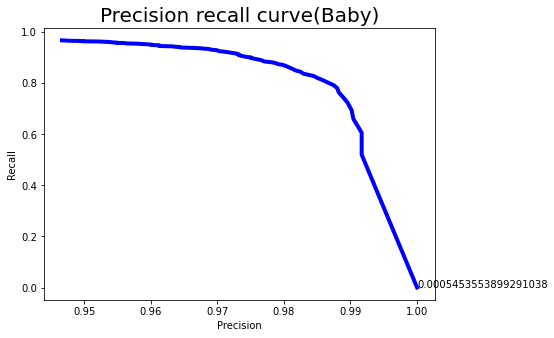

In [122]:
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(precision_all, recall_all, linewidth = 4.0, color = 'blue')
ax.set_title('Precision recall curve(Baby)', fontsize = 20)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.text(1,0,recall_all[-1])
plt.show()